<a href="https://colab.research.google.com/github/PosgradoMNA/Proyecto_A01794099/blob/main/Avance5_Equipo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

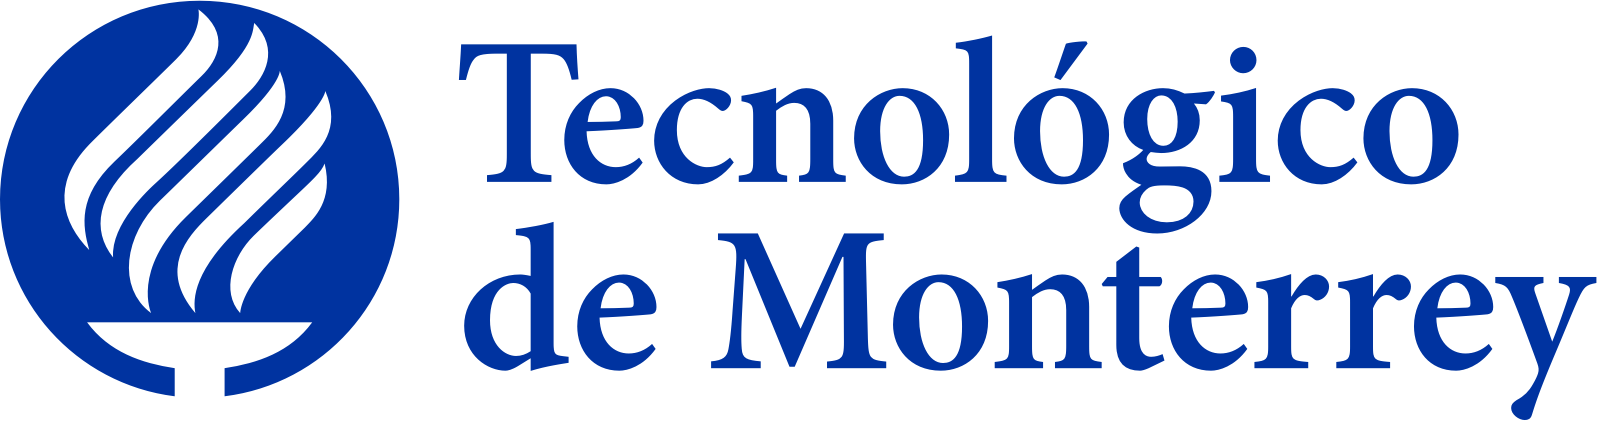

# Maestría en Inteligencia Artificial Aplicada
## Tecnológico de Monterrey
## TC5035.10 – Proyecto Integrador

### Avance 5 - Modelos Alternativos: Reconocimiento robusto de comandos de voz en robots mediante paráfrasis y clasificación k-NN

**Profesores titulares: Dra. Grettel Barceló Alonso, Dr. Luis Eduardo Falcón Morales**

**Profesor asistente: Mtra. Verónica Sandra Guzmán de Valle**


**Equipo 12:**
*   Laura Irán González Ojeda - **A01794099**

#### Indroducción

En la actividad anterior **Avance 3 - Modelos Alternativos** ([GitHub link](https://github.com/PosgradoMNA/Proyecto_A01794099/blob/main/Avance4_Equipo12.ipynb)) se exploraron 3 modelos: SBERT, LaBSE, y GPT-4 (ValGPT para propósitos internos de Intel), mostrando SBERT un buen resultado en la clasificación de comandos de acuerdo a las características del proyecto. Adicional, GPT-4 también mostró un gran comportamiento en la clasificación, siendo ahora una opción viable en la integración del proyecto. Para este entregable, sólo nos enfocaremos en el ensamble de SBERT y se agregará otro modelo LLM para comparativa, en este caso Gemini, brindando a Gemini el mismo prompt dado para ValGPT (esto con motivo de simular el comportamiento de la herramienta ValGPT).

En el ejercicio anterior, se trató de hacer el request a OpenAI, pero por motivos de licenciamento no se pudo demostrar la respuesta, es por ello que para este ejercicio se utilizará la API de Gemini.

In [1]:
#Importación del SDK de Python para la API de Gemini está contenido en el paquete `google-generativeai`
!pip install -q -U google-generativeai

In [2]:
#Importación de Librerías
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, precision_recall_curve,
    roc_auc_score, roc_curve, classification_report
)
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

import pathlib
import textwrap
from IPython.display import Markdown, display
import google.generativeai as genai
from google.colab import userdata

#### Clasificación de Comandos con SBERT: Ensamble

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ruta del archivo CSV en Google Drive
csv_file_path = '/content/drive/My Drive/Proyecto Integrador/Proyecto/data.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file_path)

# Mostrar las primeras filas del DataFrame
df.head()

,command,action
0,Shift the arm to the left,move_left
1,Position the arm to the left,move_left
2,Guide the arm to the left,move_left
3,Direct the arm towards the left,move_left
4,Adjust the arm to the left,move_left


In [5]:
# Load SBERT model from Hugging Face
tokenizer_sbert = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model_sbert = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [6]:
def get_embeddings(texts, tokenizer, model):
    # Tokenize the texts and get embeddings
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def classify_command(sentence, command_list, command_embeddings, tokenizer, model, threshold):
    # Tokenizar y codificar la oración
    inputs = tokenizer(sentence, return_tensors='pt')
    sentence_embedding = model(**inputs).last_hidden_state.mean(dim=1)

    # Compute cosine similarity with all command embeddings
    similarity_matrix = cosine_similarity(sentence_embedding.cpu().detach().numpy(), command_embeddings.cpu().detach().numpy())
    distance_matrix = 1 - similarity_matrix

    # Find the index of the most similar distance
    min_distance_idx = np.argmin(distance_matrix)
    min_distance = distance_matrix[0][min_distance_idx]

    # Check if the minimum distance is within the threshold
    if min_distance <= threshold:
        predicted_command = command_list[min_distance_idx]
    else:
        predicted_command = None  # or some other value indicating no valid match

    return predicted_command, min_distance

In [7]:
# Compute embeddings for all commands using SBERT
command_embeddings_sbert = get_embeddings(df['command'].tolist(), tokenizer_sbert, model_sbert)

In [8]:
# Define function to compute distance matrix
def compute_distance_matrix(command_embeddings):
    similarity_matrix = cosine_similarity(command_embeddings.cpu().numpy())
    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
    return distance_matrix

#Calcular la desviacion estandar
def compute_average_distance(distance_matrix):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    upper_triangular_values = distance_matrix[upper_triangular_indices]

    # Calculate the average distance
    average_distance = np.mean(upper_triangular_values)

    return average_distance

#### Graficos para Evaluación: SBERT

In [9]:
# Compute distance matrix for SBERT
distance_matrix_sbert = compute_distance_matrix(command_embeddings_sbert)

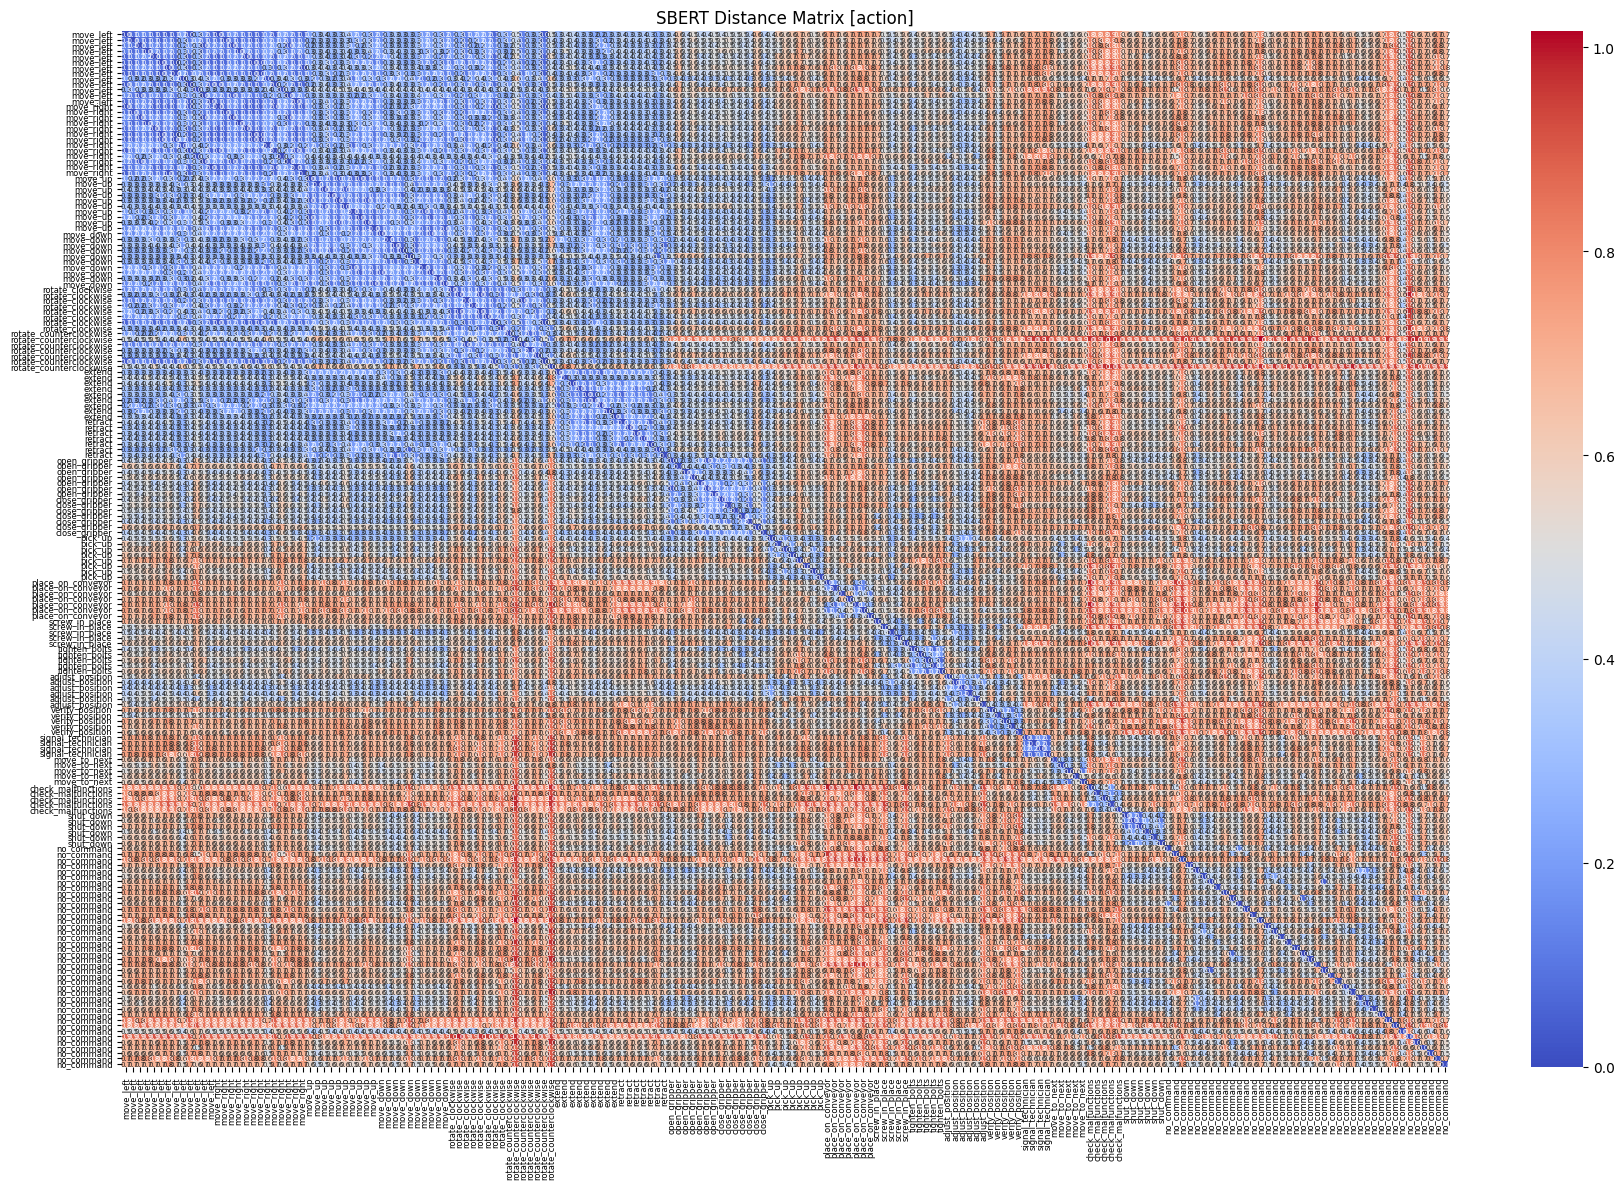

In [10]:
# Plot distance matrices
plt.figure(figsize=(18, 12))
sns.heatmap(distance_matrix_sbert, xticklabels=df['action'], yticklabels=df['action'], cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('SBERT Distance Matrix [action]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

In [11]:
def classify_command(sentence, command_list, action_list, command_embeddings, tokenizer, model, threshold):
    # Tokenizar y codificar la oración
    inputs = tokenizer(sentence, return_tensors='pt')
    sentence_embedding = model(**inputs).last_hidden_state.mean(dim=1)

    # Compute cosine similarity with all command embeddings
    similarity_matrix = cosine_similarity(sentence_embedding.cpu().detach().numpy(), command_embeddings.cpu().detach().numpy())
    distance_matrix = 1 - similarity_matrix

    # Find the index of the most similar distance
    min_distance_idx = np.argmin(distance_matrix)
    min_distance = distance_matrix[0][min_distance_idx]

    # Check if the minimum distance is within the threshold
    if min_distance <= threshold:
        predicted_action = action_list[min_distance_idx]
    else:
        predicted_action = 'None'  # No valid match

    return predicted_action, min_distance

In [12]:
def evaluate_model(command_list, action_list, command_embeddings, dataset, tokenizer, model, threshold):
    true_labels = []
    predicted_labels = []
    scores = []  # Almacena los scores de similitud para ROC y Precision-Recall

    for _, row in dataset.iterrows():
        sentence = row['command']
        label = row['action']

        # Predecir la acción utilizando classify_command
        predicted_action, score = classify_command(sentence, command_list, action_list, command_embeddings, tokenizer, model, threshold)

        predicted_labels.append(predicted_action)
        true_labels.append(label)
        scores.append(1 - score)  # Usar 1 - distancia para que funcione como un score de similitud

    # Convertir las etiquetas a formato binarizado para ROC/Precision-Recall en caso de multiclase
    classes = list(set(true_labels))
    y_true_bin = label_binarize(true_labels, classes=classes)
    y_pred_bin = label_binarize(predicted_labels, classes=classes)

    # Calcular métricas de evaluación
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Visualización de la Matriz de Confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title("Confusion Matrix")
    plt.show()

    # Curva Precision-Recall por clase
    plt.figure(figsize=(12, 5))
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
        plt.plot(recall, precision, label=f'Precision-Recall for {class_label}')
    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.show()

    # Curva ROC para cada clase
    plt.figure(figsize=(12, 5))
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        plt.plot(fpr, tpr, label=f'ROC for {class_label}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.show()

    # Análisis de Residuos: Mostrar ejemplos mal clasificados
    misclassified = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]
    print("Misclassified examples:")
    for i in misclassified:
        print(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}, Command: {dataset.iloc[i]['command']}")

    # Reporte detallado de clasificación
    report = classification_report(true_labels, predicted_labels)
    print("\nClassification Report:\n", report)

    return accuracy, f1, conf_matrix, report


En el ejercicio pasado, se obtiuvo que el mejor umbral SBER fueT: 0.37, con un F1-Score: 0.9838412646968797

In [13]:
# Umbral de distancia para clasificación
command_list = df['command'].tolist()  # Lista de comandos
action_list = df['action'].tolist()  # Lista de acciones correspondientes
threshold = 0.37

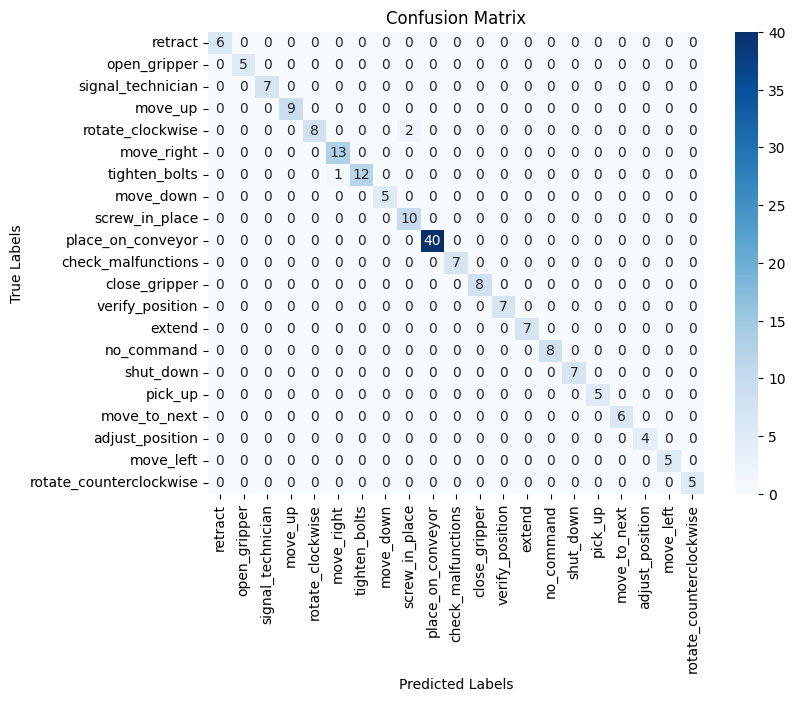

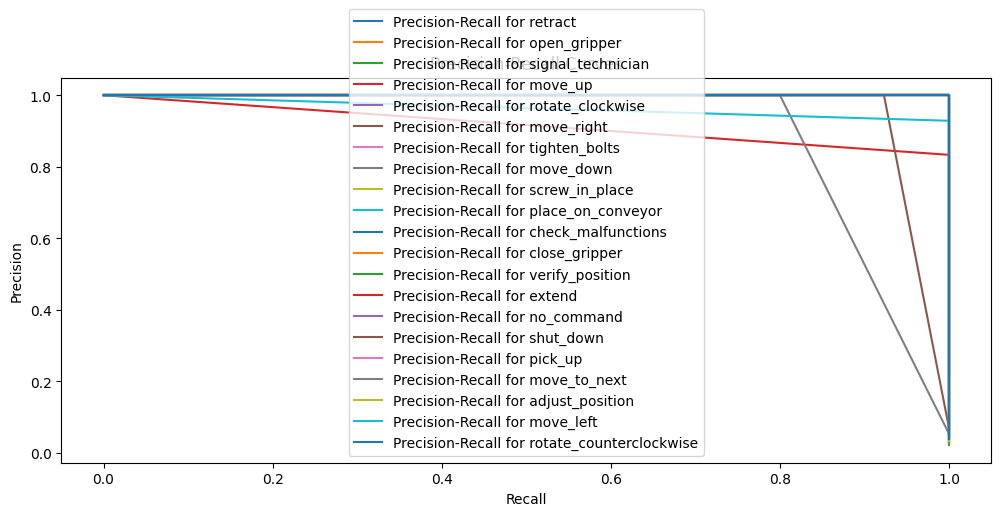

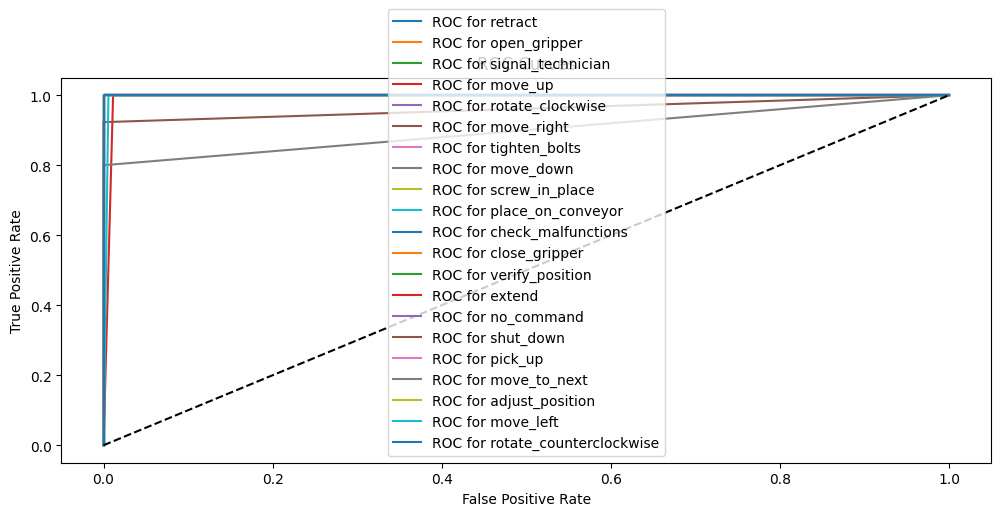

Misclassified examples:
True: move_right, Pred: move_left, Command: Move the arm toward the right side
True: move_down, Pred: move_up, Command: Lower the arm
True: move_down, Pred: move_up, Command: Move the arm slightly down

Classification Report:
                          precision    recall  f1-score   support

        adjust_position       1.00      1.00      1.00         6
     check_malfunctions       1.00      1.00      1.00         5
          close_gripper       1.00      1.00      1.00         7
                 extend       1.00      1.00      1.00         9
              move_down       1.00      0.80      0.89        10
              move_left       0.93      1.00      0.96        13
             move_right       1.00      0.92      0.96        13
           move_to_next       1.00      1.00      1.00         5
                move_up       0.83      1.00      0.91        10
             no_command       1.00      1.00      1.00        40
           open_gripper       1.0

In [14]:
# Llamada a la función con los datos y parámetros necesarios
accuracy, f1, conf_matrix, report = evaluate_model(
    command_list,
    action_list,
    command_embeddings_sbert,
    df,
    tokenizer_sbert,
    model_sbert,
    threshold
)

# Imprimir los resultados
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score (weighted): {f1:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


#### Clasificación de comandos con LLM (Gemini)

In [15]:
#Importación de la Api Key
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [16]:
#Inicialización del modelo
model = genai.GenerativeModel('gemini-1.5-pro')

In [17]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [23]:
#Generación de texto
response = model.generate_content(
    "You are a classification model. Classify the following instruction based on the given dataset and return the corresponding action. \n\n"
    "Dataset:\n"
    "{\n"
    "  \"Shift the arm to the left\": move_left,\n"
    "  \"Shift the arm to the right\": move_right,\n"
    "  \"Lift the arm upwards\": move_up,\n"
    "  \"Move the arm downwards\": move_down,\n"
    "  \"Turn the arm in a clockwise direction\": rotate_clockwise,\n"
    "  \"Turn the arm counterclockwise\": rotate_counterclockwise,\n"
    "  \"Extend the arm towards me\": extend,\n"
    "  \"Pull the arm away from me\": retract,\n"
    "  \"Release the grip\": open_gripper,\n"
    "  \"Close the gripper tightly\": close_gripper,\n"
    "  \"Lift the item\": pick_up,\n"
    "  \"Set the object on the conveyor\": place_on_conveyor,\n"
    "  \"Secure the object in place\": screw_in_place,\n"
    "  \"Tighten the screws\": tighten_bolts,\n"
    "  \"Adjust the placement of the item\": adjust_position,\n"
    "  \"Check the object's location\": verify_position,\n"
    "  \"Notify the technician when done\": signal_technician,\n"
    "  \"Move on to the next item\": move_to_next,\n"
    "  \"Look for any issues\": check_malfunctions,\n"
    "  \"Power down the system\": shut_down\n"
    "}\n\n"
    "Instruction to classify: 'Guide the arm to the left'"
)


In [24]:
markdown_text = to_markdown(response.text)
# Mostrar el texto formateado en Markdown
display(markdown_text)

> The closest match to "Guide the arm to the left" in the provided dataset is **"Shift the arm to the left"**. 
> 
> Therefore, the corresponding action is: **move_left**. 


In [25]:
#Generación de texto
response = model.generate_content(
    "You are a classification model. Classify the following instruction based on the given dataset and return the corresponding action. \n\n"
    "Dataset:\n"
    "{\n"
    "  \"Shift the arm to the left\": move_left,\n"
    "  \"Shift the arm to the right\": move_right,\n"
    "  \"Lift the arm upwards\": move_up,\n"
    "  \"Move the arm downwards\": move_down,\n"
    "  \"Turn the arm in a clockwise direction\": rotate_clockwise,\n"
    "  \"Turn the arm counterclockwise\": rotate_counterclockwise,\n"
    "  \"Extend the arm towards me\": extend,\n"
    "  \"Pull the arm away from me\": retract,\n"
    "  \"Release the grip\": open_gripper,\n"
    "  \"Close the gripper tightly\": close_gripper,\n"
    "  \"Lift the item\": pick_up,\n"
    "  \"Set the object on the conveyor\": place_on_conveyor,\n"
    "  \"Secure the object in place\": screw_in_place,\n"
    "  \"Tighten the screws\": tighten_bolts,\n"
    "  \"Adjust the placement of the item\": adjust_position,\n"
    "  \"Check the object's location\": verify_position,\n"
    "  \"Notify the technician when done\": signal_technician,\n"
    "  \"Move on to the next item\": move_to_next,\n"
    "  \"Look for any issues\": check_malfunctions,\n"
    "  \"Power down the system\": shut_down\n"
    "}\n\n"
    "Instruction to classify: 'Today is Monday?'"
)


In [26]:
markdown_text = to_markdown(response.text)
# Mostrar el texto formateado en Markdown
display(markdown_text)

> This instruction doesn't fit into any of the categories provided in the dataset.  The dataset focuses on robotic arm control and related actions. "Today is Monday?" is a question about the current day and is irrelevant to the robot's tasks. 
> 
> Therefore, a classification model would likely need to return an **"unknown"** or **"out-of-scope"** response. 


### Conclusiones

El modelo logró una exactitud general de 0.98, lo que implica un muy buen rendimiento general. En términos generales, el modelo muestra un rendimiento sólido con una precisión promedio alta y una baja tasa de errores. Los problemas se concentran en categorías con comandos de dirección, lo que podría abordarse con técnicas adicionales, como el uso de embeddings específicos para frases direccionales o el entrenamiento adicional en ejemplos ambiguos.


**Análisis de la Curva ROC - SBERT**

Se observa que las confusiones entre las clases "move_right" y "move_left" o entre "move_down" y "move_up" ocurren en comandos similares, como “Move the arm toward the right side” clasificado incorrectamente como “move_left.” Esto sugiere que el modelo podría necesitar más datos de entrenamiento para comandos que difieren en una sola dirección o están cercanos espacialmente.

Las clases que describen acciones opuestas (“move_right” vs. “move_left” y “move_down” vs. “move_up”) tienen una mayor probabilidad de confundirse, lo cual indica que el modelo podría estar captando menos diferencias contextuales en comandos de direcciones.

**Análisis del Reporte de Clasificación (Precision, Recall y F1-Score) - SBERT**

Las clases menos precisas fueron “move_down” y “move_up,” que tuvieron un recall de 0.80 y 1.00 respectivamente, mientras que la mayoría de las demás clases alcanzaron una precisión y recall perfectos (1.00). Esto muestra que el modelo clasifica consistentemente la mayoría de las categorías, salvo algunas relacionadas con movimientos verticales.

La puntuación F1 promedio ponderada de 0.98 indica que el modelo mantiene un excelente equilibrio entre precisión y recall, lo que asegura una clasificación confiable en la mayoría de los comandos.

**Análisis de la Matriz de Confusión - SBERT**

En la matriz de confusión se observan pocos errores, con las mayores confusiones localizadas en las clases “move_down” y “move_up.” Este patrón es consistente con la tendencia observada en los ejemplos de errores.

No se observaron confusiones en las clases “no_command” y otros comandos menos comunes como “signal_technician” o “verify_position.” Esto indica que el modelo reconoce muy bien estos comandos específicos, probablemente debido a su diferenciación más clara en comparación con comandos direccionales.

**Análisis de clasificación del LLM: Gemini**
Se replicó la misma solicitud a Gemini que a la tool interna de Intel, y se demostró que el LLM es capaz de realizar la clasificación de comandos de manera correcta. Un hallazgo que es importante destacar, es que en el prompt se definieron como inputs ejemplos de los comandos válidos pero no de ejemplos de comandos no validos "no_command" y el modelo fue capaz de clasificar correctamente esa oración como "unknown" or "out-of-scope".

Algo bueno en este comportamiento es que el LLM Gemini devuelve más contexto a la respuesta que no pudo clasificar, dando así una gran pauta para la comunicación final entre el robot y el humano (ingeniero, usuario final), y no sólo hacer una clasificación sino que podría existir una comunicación más dinámica y natural.

Hasta el momento SBERT y la integración del LLM son dos soluciones viables para la implementación de clasificación de comandos para el robot.

